# SNR finder ANN model training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from ler.utils import add_dict_values, append_json, get_param_from_json
import tensorflow as tf

import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import load_model

from gwsnr import antenna_response_array, cubic_spline_interpolator2d

from numba import njit

In [2]:
# # Uncomment to generate new data to test the model

# # generating astrophysical data for testing using `ler` package
# from ler.rates import LeR
# from ler.utils import get_param_from_json

# ler = LeR(verbose=False, snr_type='inner_product', waveform_approximant="IMRPhenomXPHM", spin_zero=False, spin_precession=True, z_max=5)

# size_ = 50000
# ler.batch_size = 50000
# ler.unlensed_cbc_statistics(size=size_, output_jsonfile='unlensed_param_testing.json', resume=True);

In [3]:
# let's generate IMRPhenomD (spinless) interpolartor for the snr_half (refer to gwsnr documentation)
# One of the training input is half_snr
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM', ifos=['L1', 'H1', 'V1'])

You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_5.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10

### Input-Output generator function

In [4]:
def input_output(idx, params):
    """
        Function to generate input and output data for the neural network

        Parameters:
        idx: index of the parameter points
        params: dictionary of parameter points
            params.keys() = ['mass_1', 'mass_2', 'luminosity_distance', 'theta_jn', 'psi', 'geocent_time', 'ra', 'dec', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'L1']

        Returns:
        X: input data, [snr_half_[0], amp0[0], eta, chi_eff, theta_jn]
        y: output data, [L1]
    """

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] = 1 / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


    # input data
    XL1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff, theta_jn]).T
    XH1 = np.vstack([snr_half_[1], amp0[1], eta, chi_eff, theta_jn]).T
    XV1 = np.vstack([snr_half_[2], amp0[2], eta, chi_eff, theta_jn]).T

    # output data
    # get snr for y train
    yL1 = np.array(params['L1'])[idx]*luminosity_distance
    yH1 = np.array(params['H1'])[idx]*luminosity_distance
    yV1 = np.array(params['V1'])[idx]*luminosity_distance
    yNET = np.sqrt(yL1**2 + yH1**2 + yV1**2)/luminosity_distance

    return(XL1, yL1, XH1, yH1, XV1, yV1, yNET, luminosity_distance)


def get_index(X_test, XL1):
    idx_test = np.zeros_like(X_test)
    for i in range(len(X_test)):
        idx_test[i] = np.where(XL1==X_test[i])[0][0]

    return idx_test.astype(int)

## For L1 detector

### Get all necessary data

In [5]:
# these are pre-generated datas
# join all dictionaries into one
# the naming of data files are based on what you have saved. Refer to 'training_data_generation_ann.ipynb' to see how the data is generated with `ler` package and saved.
unlensed_params = get_param_from_json("snr_L1.json")
unlensed_params3 = get_param_from_json("joint_new_optsnr2.json")
unlensed_params4 = get_param_from_json("joint_new_optsnr3.json")
unlensed_params5 = get_param_from_json("joint_new_optsnr4.json")
unlensed_params6 = get_param_from_json("joint_new_optsnr5.json")
unlensed_params7 = get_param_from_json("joint_new_optsnr6.json")
unlensed_params8 = get_param_from_json("joint_new_optsnr_uniform.json")

unlensed_params = add_dict_values(unlensed_params, unlensed_params3)
unlensed_params = add_dict_values(unlensed_params, unlensed_params4)
unlensed_params = add_dict_values(unlensed_params, unlensed_params5)
unlensed_params = add_dict_values(unlensed_params, unlensed_params6)
unlensed_params = add_dict_values(unlensed_params, unlensed_params7)
unlensed_params = add_dict_values(unlensed_params, unlensed_params8)
del unlensed_params8
del unlensed_params3, unlensed_params4, unlensed_params5, unlensed_params6, unlensed_params7
print(f"size before SNR cut: {len(unlensed_params['L1'])}")
# set SNR cut
idx_constrain = unlensed_params['L1']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

print(f"size after SNR cut: {len(unlensed_params['L1'])}")

size before SNR cut: 428819
size after SNR cut: 417189


In [6]:
len_ = len(unlensed_params['L1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XL1, yL1, _, _, _, _,_,dl = input_output(idx, unlensed_params)
np.shape(XL1)

(417189, 5)

* It is expected to have larger error in the sparse region of the input data, e.g. $\eta<0.2$

### Scaling the data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(XL1, yL1, test_size = 0.1, random_state = 0)
idx_test = get_index(X_test[:,0], XL1[:,0])
dl_test = dl[idx_test]

In [9]:
# # Uncomment the following if you have already generated the scaler

# # load the scaler
# scalerL1 = pickle.load(open('scalerL1_final2.pkl', 'rb'))
# sc = scalerL1
# X_train = sc.transform(X_train)
# X_test = sc.transform(X_test)

# Uncomment the following if you have not generated the scaler

# feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
pickle.dump(sc, open('scalerL1_final2.pkl', 'wb'))

### Generate ANN model

In [10]:
# Uncomment the following if you have already trained the model

# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
# units=5, where 5 is the number of neurons in the first input layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))

# compile the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 50)

Epoch 1/50
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 5s 338us/step - accuracy: 0.0000e+00 - loss: 531101024.0000
Epoch 2/50
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 4s 350us/step - accuracy: 0.0000e+00 - loss: 521054784.0000
Epoch 3/50
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 4s 350us/step - accuracy: 0.0000e+00 - loss: 513758848.0000
Epoch 4/50
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 4s 353us/step - accuracy: 0.0000e+00 - loss: 500974592.0000
Epoch 5/50
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 4s 366us/step - accuracy: 0.0000e+00 - loss: 491864288.0000
Epoch 6/50
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 4s 339us/step - accuracy: 0.0000e+00 - loss: 479319936.0000
Epoch 7/50
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 4s 345us/step - accuracy: 0.0000e+00 - loss: 469900064.0000
Epoch 8/50
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 4s 329us/step - accuracy: 0.0000e+00 - loss: 460366304.0000
Epoch 9/50
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 4s 341us/step - accuracy: 0.0000e+00 - loss: 450185216.0000
Epoch 10/50
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 4s 356us/step - acc

In [11]:
# Uncomment the following if you have not trained the model

# Save the model to a file
ann.save('ann_modelL1_final2.h5')
modelL1 = ann

In [12]:
# Uncomment the following if you have already generated the model

# load the model
from tensorflow.keras.models import load_model
modelL1 = load_model('ann_modelL1_final2.h5')

### Test the Model on the test data

In [13]:
# left: predicted snr*dl, right: actual snr*dl
y_pred = modelL1.predict(X_test).flatten()/dl_test
y_true = y_test/dl_test
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_true.reshape(len(y_true),1)),1))

1304/1304 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
[[ 3.29086844  4.38644446]
 [ 4.09272217  4.64245177]
 [ 2.0057697   2.88138791]
 ...
 [ 1.28121643  1.39248947]
 [ 7.46031639  3.99619515]
 [10.63120258 16.37039099]]


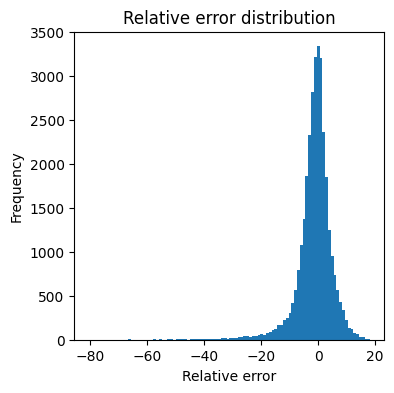

In [14]:
# error distribution
idx = (y_pred>2) & (y_pred<20)
idx = idx & (y_test!=0)
y_pred_ = y_pred[idx]
y_true_ = y_true[idx]

plt.figure(figsize=(4,4))
plt.hist(y_pred_-y_true_, bins=100)
plt.xlabel('Relative error')
plt.ylabel('Frequency')
plt.title('Relative error distribution')
plt.show()

### Test with astrophysical parameters

In [15]:
# Get the data. This data is generated using `ler` package.
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing.json")
X_, Y_,_,_,_,_,_,dl = input_output(np.arange(len(unlensed_params['L1'])), unlensed_params)
scalerL1 = pickle.load(open('scalerL1_final2.pkl', 'rb'))
X_ = scalerL1.transform(X_)

y_pred_ = modelL1.predict(X_).flatten()/dl
y_true_ = Y_/dl
cm = confusion_matrix((y_true_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_true_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step
[[49838    99]
 [   28    35]]
Accuracy: 99.746%


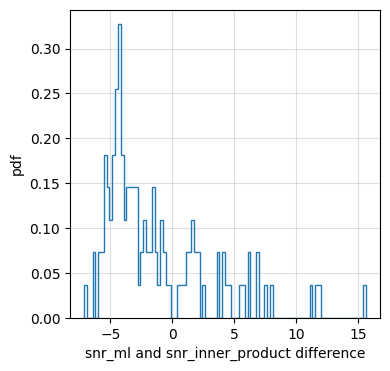

In [16]:
# y_pred_ = modelL1.predict(X_).flatten()
# y_test_ = Y_.copy()
# y_test = Y_
hist_ = y_pred_-y_true_
idx = (y_true_>6) & (y_true_<10)  # selection wrt snr
# idx = idx & (X_[:,2]>-2)  # selection wrt eta
hist_ = hist_[idx]
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=100, histtype='step', density=True)
# plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

* not good enough

In [32]:
idx = (y_pred_>4)&(y_pred_<10)
y_pred = y_pred_[idx]
y_true = y_true_[idx]
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_true.reshape(len(y_true),1)),1)[10:25])

[[4.50827322 3.89710769]
 [4.14749742 4.33615409]
 [4.05061945 4.40511338]
 [4.4080634  6.53987562]
 [4.28277849 4.28398339]
 [5.38910224 4.88480809]
 [7.62235847 7.64317072]
 [6.14288915 6.45474988]
 [4.42235409 4.34786309]
 [5.1236819  5.31394697]
 [4.34959218 5.49669684]
 [4.19277564 3.27550753]
 [4.0038338  7.42176855]
 [4.00365663 4.37354735]
 [5.67748522 6.43454205]]


### Error analysis

In [40]:
# do linear fitting of the error y_pred-y_test
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*x + b

idx = (y_pred_>4) & (y_pred_<10)
idx = idx & (y_test_!=0)
popt, pcov = curve_fit(func, y_pred_[idx], y_pred_[idx]-y_test_[idx])
print(f"slope: {popt[0]:.4f}, intercept: {popt[1]:.4f}")

a,b = popt
y_pred_ = modelL1.predict(X_).flatten()
y_pred_ = y_pred_-(a*y_pred_ + b)
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy (after error ajustment): {accuracy:.3f}%")

slope: -0.0160, intercept: -0.0015
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
[[49885    52]
 [    6    57]]
Accuracy (after error ajustment): 99.884%


In [42]:
# save adjustment function as pickle
def correction(x):
    a = -0.0160
    b = -0.0015
    return a*x + b

pickle.dump(correction, open('correctionL1_final.pkl', 'wb'))

[[16113.72558594 15822.5221076 ]
 [23815.27929688 22344.25827187]
 [ 9811.81542969  7737.96259477]
 ...
 [23815.28125    36043.07212574]
 [12603.15234375 12575.07867475]
 [ 3247.22509766  2306.1364013 ]]


## H1

In [64]:
# the naming of data files are based on what you have saved. Refer to 'training_data_generation_ann.ipynb' to see how the data is generated with `ler` package and saved.

# joint all dict
unlensed_params = get_param_from_json("snr_H1.json")
unlensed_params3 = get_param_from_json("joint_new_optsnr2.json")
unlensed_params4 = get_param_from_json("joint_new_optsnr3.json")
unlensed_params5 = get_param_from_json("joint_new_optsnr4.json")
unlensed_params6 = get_param_from_json("joint_new_optsnr5.json")
unlensed_params7 = get_param_from_json("joint_new_optsnr6.json")
unlensed_params8 = get_param_from_json("joint_new_optsnr_uniform.json")
unlensed_params = add_dict_values(unlensed_params, unlensed_params3)
unlensed_params = add_dict_values(unlensed_params, unlensed_params4)
unlensed_params = add_dict_values(unlensed_params, unlensed_params5)
unlensed_params = add_dict_values(unlensed_params, unlensed_params6)
unlensed_params = add_dict_values(unlensed_params, unlensed_params7)
unlensed_params = add_dict_values(unlensed_params, unlensed_params8)
del unlensed_params8
del unlensed_params3, unlensed_params4, unlensed_params5, unlensed_params6, unlensed_params7
print(f"size before SNR cut: {len(unlensed_params['H1'])}")
# set SNR cut
# this is optimise the ANN by ignoring the high SNR
idx_constrain = unlensed_params['H1']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

print(f"size after SNR cut: {len(unlensed_params['H1'])}")

size before SNR cut: 425469
size after SNR cut: 413822


In [65]:
len_ = len(unlensed_params['H1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
_, _, XH1, yH1, _, _, _ = input_output(idx, unlensed_params)
np.shape(XH1)

(413822, 5)

### Feature scaling

In [66]:
X_train, X_test, y_train, y_test = train_test_split(XH1, yH1, test_size = 0.1, random_state = 0)

# # Uncomment the following if you have already generated the scaler

# # load the scaler
# scalerH1 = pickle.load(open('scalerH1_final.pkl', 'rb'))
# sc = scalerH1
# X_train = sc.transform(X_train)
# X_test = sc.transform(X_test)

# Uncomment the following if you have not generated the scaler

# feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
pickle.dump(sc, open('scalerH1_final.pkl', 'wb'))

In [67]:
# Uncomment the following if you have already trained the model

# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
# units=5, where 5 is the number of neurons in the first input layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))

# compile the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
11639/11639 ━━━━━━━━━━━━━━━━━━━━ 4s 346us/step - accuracy: 3.0232e-05 - loss: 78.3699
Epoch 2/100
11639/11639 ━━━━━━━━━━━━━━━━━━━━ 4s 354us/step - accuracy: 0.0000e+00 - loss: 5.5597
Epoch 3/100
11639/11639 ━━━━━━━━━━━━━━━━━━━━ 4s 343us/step - accuracy: 0.0000e+00 - loss: 5.3319
Epoch 4/100
11639/11639 ━━━━━━━━━━━━━━━━━━━━ 4s 336us/step - accuracy: 3.8461e-06 - loss: 5.1318
Epoch 5/100
11639/11639 ━━━━━━━━━━━━━━━━━━━━ 4s 334us/step - accuracy: 2.7003e-06 - loss: 5.2215
Epoch 6/100
11639/11639 ━━━━━━━━━━━━━━━━━━━━ 4s 336us/step - accuracy: 7.1926e-06 - loss: 5.2535
Epoch 7/100
11639/11639 ━━━━━━━━━━━━━━━━━━━━ 4s 349us/step - accuracy: 1.3457e-05 - loss: 5.1201
Epoch 8/100
11639/11639 ━━━━━━━━━━━━━━━━━━━━ 4s 368us/step - accuracy: 3.4992e-06 - loss: 5.0459
Epoch 9/100
11639/11639 ━━━━━━━━━━━━━━━━━━━━ 4s 360us/step - accuracy: 5.2687e-06 - loss: 4.9651
Epoch 10/100
11639/11639 ━━━━━━━━━━━━━━━━━━━━ 4s 357us/step - accuracy: 1.1979e-06 - loss: 5.1233
Epoch 11/100
11639/11639 ━━━

In [68]:
# Uncomment the following if you have not trained the model

# Save the model to a file
ann.save('ann_modelH1_final.h5')
modelH1 = ann

In [69]:
# # Uncomment the following if you have already generated the model

# # load the model
# modelH1 = load_model('ann_modelH1_final.h5')

### Test the Model on the test data

In [70]:
# left: predicted snr, right: actual snr
y_pred = modelH1.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

1294/1294 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
[[ 4.96230125  4.84736541]
 [ 7.58518314  7.64844737]
 [ 1.84228086  1.58306088]
 [21.90776062 24.89381283]
 [ 2.82919002  1.22388503]
 [ 3.93394399  4.19605154]
 [ 6.33704376  7.1175841 ]
 [12.63951111 10.88828453]
 [10.32448864  9.23047953]
 [ 4.10675144  4.2330612 ]
 [ 4.29956722  3.81040391]
 [17.14282608 16.21788563]
 [35.83976364 33.74693141]
 [ 6.28044415  5.6103741 ]
 [ 3.06850338  2.23600285]]


In [71]:
# calculate the error
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 3.95%


### Test with astrophysical parameters

In [72]:
# Get the data. This data is generated using `ler` package.
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing.json")
_, _, X_, Y_, _, _, _ = input_output(np.arange(len(unlensed_params['H1'])), unlensed_params)
scalerH1 = pickle.load(open('scalerH1_final.pkl', 'rb'))
X_ = scalerH1.transform(X_)

y_pred_ = modelH1.predict(X_).flatten()-0.2
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
[[49904    41]
 [   10    45]]
Accuracy: 99.898%


### Error analysis

In [73]:
# do linear fitting of the error y_pred-y_test
def func(x, a, b):
    return a*x + b

idx = (y_pred_>4) & (y_pred_<10)
idx = idx & (y_test_!=0)
popt, pcov = curve_fit(func, y_pred_[idx], y_pred_[idx]-y_test_[idx])
print(f"slope: {popt[0]:.4f}, intercept: {popt[1]:.4f}")

a,b = popt
y_pred_ = modelH1.predict(X_).flatten()
y_pred_ = y_pred_-(a*y_pred_ + b)
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy (after error ajustment): {accuracy:.3f}%")

slope: -0.0183, intercept: 0.1145
   1/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
[[49902    43]
 [    7    48]]
Accuracy (after error ajustment): 99.900%


In [74]:
# save adjustment function as pickle
def correction(x):
    a = -0.0183
    b = 0.1145
    return a*x + b

pickle.dump(correction, open('correctionH1_final.pkl', 'wb'))

## V1

In [75]:
# these are pre-generated datas
# join all dictionaries into one
# the naming of data files are based on what you have saved. Refer to 'training_data_generation_ann.ipynb' to see how the data is generated with `ler` package and saved.
unlensed_params = get_param_from_json("snr_V1.json")
unlensed_params3 = get_param_from_json("joint_new_optsnr2.json")
unlensed_params4 = get_param_from_json("joint_new_optsnr3.json")
unlensed_params5 = get_param_from_json("joint_new_optsnr4.json")
unlensed_params6 = get_param_from_json("joint_new_optsnr5.json")
unlensed_params7 = get_param_from_json("joint_new_optsnr6.json")
unlensed_params8 = get_param_from_json("joint_new_optsnr_uniform.json")

unlensed_params = add_dict_values(unlensed_params, unlensed_params3)
unlensed_params = add_dict_values(unlensed_params, unlensed_params4)
unlensed_params = add_dict_values(unlensed_params, unlensed_params5)
unlensed_params = add_dict_values(unlensed_params, unlensed_params6)
unlensed_params = add_dict_values(unlensed_params, unlensed_params7)
unlensed_params = add_dict_values(unlensed_params, unlensed_params8)
del unlensed_params8
del unlensed_params3, unlensed_params4, unlensed_params5, unlensed_params6, unlensed_params7
print(f"size before SNR cut: {len(unlensed_params['V1'])}")
# set SNR cut
idx_constrain = unlensed_params['V1']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

print(f"size after SNR cut: {len(unlensed_params['V1'])}")

size before SNR cut: 409441
size after SNR cut: 400502


In [77]:
len_ = len(unlensed_params['V1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
_, _, _, _, XV1, yV1,_ = input_output(idx, unlensed_params)
np.shape(XV1)

(400502, 5)

### Feature scaling

In [78]:
X_train, X_test, y_train, y_test = train_test_split(XV1, yV1, test_size = 0.1, random_state = 0)

# # Uncomment the following if you have already generated the scaler

# # load the scaler
# scalerV1 = pickle.load(open('scalerV1_final.pkl', 'rb'))
# sc = scalerV1
# X_train = sc.transform(X_train)
# X_test = sc.transform(X_test)

# Uncomment the following if you have not generated the scaler

# feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
pickle.dump(sc, open('scalerV1_final.pkl', 'wb'))

### Generate ANN model

In [79]:
# Uncomment the following if you have already trained the model

# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
# units=5, where 5 is the number of neurons in the first input layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))

# compile the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
11265/11265 ━━━━━━━━━━━━━━━━━━━━ 4s 349us/step - accuracy: 0.0000e+00 - loss: 66.0442
Epoch 2/100
11265/11265 ━━━━━━━━━━━━━━━━━━━━ 4s 394us/step - accuracy: 1.0463e-06 - loss: 4.9734
Epoch 3/100
11265/11265 ━━━━━━━━━━━━━━━━━━━━ 4s 366us/step - accuracy: 1.5519e-05 - loss: 4.9371
Epoch 4/100
11265/11265 ━━━━━━━━━━━━━━━━━━━━ 4s 348us/step - accuracy: 2.1632e-05 - loss: 4.6072
Epoch 5/100
11265/11265 ━━━━━━━━━━━━━━━━━━━━ 4s 373us/step - accuracy: 4.6026e-06 - loss: 4.5132
Epoch 6/100
11265/11265 ━━━━━━━━━━━━━━━━━━━━ 4s 361us/step - accuracy: 3.7494e-06 - loss: 4.4700
Epoch 7/100
11265/11265 ━━━━━━━━━━━━━━━━━━━━ 4s 372us/step - accuracy: 1.4966e-05 - loss: 4.5616
Epoch 8/100
11265/11265 ━━━━━━━━━━━━━━━━━━━━ 4s 360us/step - accuracy: 3.3881e-05 - loss: 4.4328
Epoch 9/100
11265/11265 ━━━━━━━━━━━━━━━━━━━━ 4s 373us/step - accuracy: 9.4721e-06 - loss: 4.1724
Epoch 10/100
11265/11265 ━━━━━━━━━━━━━━━━━━━━ 4s 376us/step - accuracy: 2.6220e-05 - loss: 4.2867
Epoch 11/100
11265/11265 ━━━

In [80]:
# Uncomment the following if you have not trained the model

# Save the model to a file
ann.save('ann_modelV1_final.h5')
modelV1 = ann

In [81]:
# # Uncomment the following if you have already generated the model

# # load the model
# from tensorflow.keras.models import load_model
# modelV1 = load_model('ann_modelV1_final.h5')

### Test the Model on the test data

In [82]:
# left: predicted snr, right: actual snr
y_pred = modelV1.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

1252/1252 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
[[ 7.46294022  8.70183896]
 [ 1.69532633  1.87707504]
 [ 3.07540035  3.11496932]
 [ 1.52323031  4.23938419]
 [ 3.91678762  3.89805523]
 [ 3.05808353  3.02651082]
 [11.61040783 12.25064902]
 [ 3.59612608  3.95771974]
 [ 0.59179592  0.28101124]
 [ 2.19164467  2.48095565]
 [18.86106873 26.64630974]
 [18.74502563 18.13633037]
 [ 5.89695787  6.27602427]
 [ 1.43439698  1.50413673]
 [ 5.90137959  6.97998785]]


In [83]:
# calculate the error
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 2.46%


### Test with astrophysical parameters

In [88]:
# Get the data. This data is generated using `ler` package.
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing.json")
_,_,_,_,X_,Y_,_ = input_output(np.arange(len(unlensed_params['V1'])), unlensed_params)
scalerV1 = pickle.load(open('scalerV1_final.pkl', 'rb'))
X_ = scalerV1.transform(X_)

y_pred_ = modelV1.predict(X_).flatten()
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 319us/step
[[49696   227]
 [    6    71]]
Accuracy: 99.562%


### Error analysis

In [95]:
# do linear fitting of the error y_pred-y_test
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*x + b

idx = (y_pred_>4) & (y_pred_<10)
idx = idx & (y_test_!=0)
popt, pcov = curve_fit(func, y_pred_[idx], y_pred_[idx]-y_test_[idx])
print(f"slope: {popt[0]:.4f}, intercept: {popt[1]:.4f}")

a,b = popt
y_pred_ = modelV1.predict(X_).flatten()
y_pred_ = y_pred_-(a*y_pred_ + b)
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy (after error ajustment): {accuracy:.3f}%")

slope: 0.0119, intercept: 0.0019
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step
[[49758   212]
 [    6    24]]
Accuracy (after error ajustment): 99.564%


In [96]:
# save adjustment function as pickle
def correction(x):
    a = -0.0160
    b = -0.0015
    return a*x + b

pickle.dump(correction, open('correctionV1_final.pkl', 'wb'))

### L1, H1, V1, NET

### Load the models, scalers and correction functions

In [100]:
# load the ANN models
modelL1 = load_model('ann_modelL1_final.h5')
modelH1 = load_model('ann_modelH1_final.h5')
modelV1 = load_model('ann_modelV1_final.h5')

# load the feature scaler
scalerL1 = pickle.load(open('scalerL1_final.pkl', 'rb'))
scalerH1 = pickle.load(open('scalerH1_final.pkl', 'rb'))
scalerV1 = pickle.load(open('scalerV1_final.pkl', 'rb'))

# load the correction functions
correctionL1 = pickle.load(open('correctionL1_final.pkl', 'rb'))
correctionH1 = pickle.load(open('correctionH1_final.pkl', 'rb'))
correctionV1 = pickle.load(open('correctionV1_final.pkl', 'rb'))

In [101]:
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing.json")

In [102]:
XL1, yL1, XH1, yH1, XV1, yV1, yNET = input_output(np.arange(len(unlensed_params['optimal_snr_net'])), unlensed_params)

In [108]:
def predict_snr_net_ANN(XL1, XH1, XV1):
    """
        Function to predict the network SNR using the ANN models

        Parameters:
        XL1: input data for L1, [snr_half_[0], amp0[0], eta, chi_eff, theta_jn]
        XH1: input data for H1, [snr_half_[1], amp0[1], eta, chi_eff, theta_jn]
        XV1: input data for V1, [snr_half_[2], amp0[2], eta, chi_eff, theta_jn]

        Returns:
        y: network SNR
    """
    x = scalerL1.transform(XL1)
    yL1 = modelL1.predict(x)
    yL1 = yL1 - correctionL1(yL1)
    x = scalerH1.transform(XH1)
    yH1 = modelH1.predict(x)
    yH1 = yH1 - correctionH1(yH1)
    x = scalerV1.transform(XV1)
    yV1 = modelV1.predict(x)
    yV1 = yV1 - correctionV1(yV1)
    y = np.sqrt(yL1**2 + yH1**2 + yV1**2)

    mass_1 = np.array(unlensed_params['mass_1'])
    mass_2 = np.array(unlensed_params['mass_2'])
    mtot = mass_1 + mass_2
    y[mtot>gwsnr.mtot_max] = 0.

    return(y)

In [112]:
# left: predicted snr, right: actual snr
y_pred = predict_snr_net_ANN(XL1, XH1, XV1)

print(np.concatenate((y_pred.reshape(len(y_pred),1), yNET.reshape(len(yNET),1)),1)[20:35])

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
[[3.02149487 2.46947355]
 [1.28021622 0.95998231]
 [1.65902102 1.33613099]
 [4.56972122 4.74315895]
 [1.52131796 1.46595642]
 [2.12464452 1.65085218]
 [1.50326741 1.23096579]
 [1.96091294 1.9887877 ]
 [1.56352234 1.03065928]
 [1.92406559 1.74055025]
 [1.59190059 0.86150242]
 [1.60674    1.39648025]
 [3.46959639 2.51472319]
 [1.15084291 0.37194413]
 [2.13587236 1.29327945]]


In [117]:
y_pred_ = predict_snr_net_ANN(XL1, XH1, XV1).flatten()
y_test_ = yNET
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
[[49712    39]
 [   16   233]]
Accuracy: 99.890%


### Error analysis

In [118]:
# do linear fitting of the error y_pred-y_test
def func(x, a, b):
    return a*x + b

idx = (y_pred_>4) & (y_pred_<10)
idx = idx & (y_test_!=0)
popt, pcov = curve_fit(func, y_pred_[idx], y_pred_[idx]-y_test_[idx])
print(f"slope: {popt[0]:.4f}, intercept: {popt[1]:.4f}")

a,b = popt
y_pred_ = y_pred_-(a*y_pred_ + b)
# y_pred_ = predict_snr_net_ANN(XL1, XH1, XV1).flatten()
# y_test_ = yNET
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy (after error ajustment): {accuracy:.3f}%")

slope: 0.0211, intercept: 0.1631
[[49731    20]
 [   29   220]]
Accuracy (after error ajustment): 99.902%


In [119]:
# save adjustment function as pickle
def correction(x):
    a = 0.0211
    b = 0.1631
    return a*x + b

pickle.dump(correction, open('correctionNET_final.pkl', 'wb'))

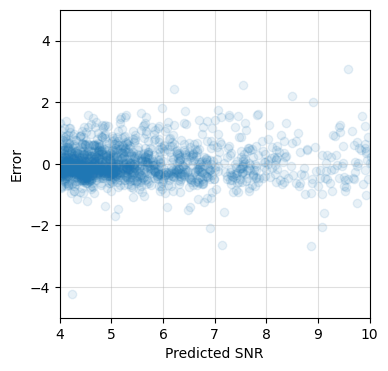

In [121]:
idx = (y_pred_>4) & (y_pred_<12)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], y_pred_[idx]-y_test_[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
#plt.xscale("log")
plt.xlim(4,10)
plt.ylabel("Error")
plt.ylim(-5,5)
plt.grid(alpha=0.4)
plt.show()

* The error is confined to $\text{SNR}_{-3}^{+3}$, near SNR=8.